# Experimental Model Mark III: MLP

For reference: best baseline MLP Classifier on TSNV hidden_layer_sizes=(3072, 1024, 1024, 1024, 256): f1-score \[0.82739 0.87162 0.78970 0.77660\] average 0.81633 (alt. run 0.82256, alpha=0.01 => 0.82789)

### Imports and reading the dataset

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5633; Dev set size: 626; Testing set size: 696


In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Constants
MAX_ITERS = 1000

### Tools

In [4]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/experimental_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

In [5]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [9]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [14]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    if isinstance(clf, MultiOutputRegressor) or isinstance(clf, MLPRegressor):
        all_preds = np.clip(clf.predict(dataset_X), 0,1)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = all_preds
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = all_preds
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

### MLP Classifier
---
#### Initial misadventures: dated up to 7 April 2022

The first batch of configurations were generic attempts to recreate the good results from last time.  
Loss struggles to get below 0.4; seems the premium for breadth (1st layer size) has two peaks (1024 and ca. 8192-12288) and depth limit is somewhere around 5 layers.

hidden_layer_sizes=(100, 50, 25, 12): 0.52437       
hidden_layer_sizes=(1024, 1024, 1024, 1024): 0.58583       
hidden_layer_sizes=(1024, 1024, 1024, 1024, 1024): 0.59222     
hidden_layer_sizes=(1024, 1024, 1024, 1024, 1024, 1024): 0.45770       
hidden_layer_sizes=(2048, 1024, 1024, 1024, 1024): 0.55112  
hidden_layer_sizes=(3072, 1024, 256), no other hyperparams: average 0.54554  
hidden_layer_sizes=(3072, 1024, 1024, 1024, 256), no other hyperparams: average 0.31389   
hidden_layer_sizes=(3072,1024,1024,1024,1024), batch_size=64: 0.63653       
hidden_layer_sizes=(4096, 2048, 1024, 1024, 512): 0.53178       
hidden_layer_sizes=(5120, 2048, 1024): 0.41117    
hidden_layer_sizes=(8192, 2048, 1024): 0.54973  
hidden_layer_sizes=(8192, 2048, 1024, 1024, 2014): mind the typo, but 0.58619    
hidden_layer_sizes=(10240, 1024, 1024, 1024, 1024): 0.49139       
hidden_layer_sizes=(12288, 2048, 1024): 0.55877       
hidden_layer_sizes=(12288, 2048, 1024, 1024, 1024): 0.58475       
hidden_layer_sizes=(16384, 2048, 1024): 0.52749       
hidden_layer_sizes=(16384, 2048, 1024, 1024, 1024): 0.40317       

A better strategy is to use (x, x/128) in a two-layer design, The choice of x/128 in layer 2 and the choice of 2 layers verified using grid search. It generally gave average f1 scores >= 0.6.

hidden_layer_sizes=(65536, 512): 0.59838

---
#### Later attempts
A breakthrough was made when it turns out a much smaller batch size will be necessary. At a batch size of 32, the hidden_layer_sizes=(3072, 1024, 1024, 1024, 256) configuration had 0.70 average f1 score, which was gooder than the rest. Nonetheless, loss refused to go below 0.2 most of the time.

hidden_layer_sizes=(16384, 128), batch_size=16: average f1 0.57022  
hidden_layer_sizes=(3072, 1024, 256), batch_size=16: average f1 0.62683  
hidden_layer_sizes=(3072, 1024, 1024, 1024, 256), batch_size=16: average f1 0.61411  

hidden_layer_sizes=(2048, 128), batch_size=32: average f1 0.61063   
hidden_layer_sizes=(3072, 128), batch_size=32: average f1 0.62410  
hidden_layer_sizes=(3072, 256), batch_size=32: average f1 0.65237    
hidden_layer_sizes=(3072, 512), batch_size=32: average f1 0.59646   
hidden_layer_sizes=(3072, 256, 256), batch_size=32: average f1 0.000  
hidden_layer_sizes=(3072, 512, 256), batch_size=32: average f1 0.64813  
hidden_layer_sizes=(3072, 512, 256, 256), batch_size=32: average f1 0.75477    
hidden_layer_sizes=(3072, 512, 128), batch_size=32: average f1 0.64570   
hidden_layer_sizes=(3072, 512, 512), batch_size=32: average f1 0.61379  
hidden_layer_sizes=(3072, 1024, 256), batch_size=32: average f1 0.64135    
hidden_layer_sizes=(4096, 128), batch_size=32: average f1 0.61086  
hidden_layer_sizes=(8192, 128), batch_size=32: average f1 0.44960  

(grid search happened, skip several configs)  
hidden_layer_sizes=(3072, 512, 256, 64): average  
hidden_layer_sizes=(3072, 512, 256, 128): below average  
hidden_layer_sizes=(3072, 512, 256, 256): average f1 0.75477  
hidden_layer_sizes=(3072, 512, 512, 256): below average  
hidden_layer_sizes=(3072, 1024, 512, 256): average f1 0.66802   
hidden_layer_sizes=(3072, 1024, 512, 256, 256): average f1 0.59475  
hidden_layer_sizes=(3072, 2048, 256, 256): average f1 0.69678     
hidden_layer_sizes=(3072, 2048, 512, 128): average f1 0.75001    
hidden_layer_sizes=(3072, 2048, 512, 256): average f1 0.74114    
hidden_layer_sizes=(3072, 2048, 1024, 256): average f1 **0.80366**   
hidden_layer_sizes=(3072, 2048, 1024, 512): average f1 0.72247     
hidden_layer_sizes=(3072, 2048, 1024, 512, 256): average  
hidden_layer_sizes=(3072, 2048, 1024, 256, 128): above average, f1 0.67955  
hidden_layer_sizes=(3072, 2048, 1024, 1024, 512): average f1 0.73324  
hidden_layer_sizes=(3072, 2048, 2048, 2048, 1024): above average ?

Quick conclusions:
1st layer 3072 is best  
2nd layer 256 is best when less than 3 layers  
3rd layer: (3072, 512, 256) best  
4th layer: (3072, 512, 256, 256) and (3072, 2048, 1024, 256) best  
  - last layer 256 is best, at least not smaller than previous layer  
  - 2nd 2048 and 3rd layer 1024  
  
5th layer: not very necessary  


In [13]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(3072, 2048, 2048, 2048, 1024), batch_size=32,
    alpha=0.01,
    max_iter=MAX_ITERS,
    shuffle=True,
    verbose=True,
    random_state=42
)

mlp_clf = mlp_clf.fit(train_X, train_Y)

Iteration 1, loss = 3.66361745
Iteration 2, loss = 1.43164205
Iteration 3, loss = 1.33539853
Iteration 4, loss = 1.30924752
Iteration 5, loss = 1.25803468
Iteration 6, loss = 1.20776292
Iteration 7, loss = 1.22689055
Iteration 8, loss = 1.24241635
Iteration 9, loss = 1.24686244
Iteration 10, loss = 1.17533269
Iteration 11, loss = 1.14685326
Iteration 12, loss = 1.12689846
Iteration 13, loss = 1.10728780
Iteration 14, loss = 1.08621495
Iteration 15, loss = 1.07155102
Iteration 16, loss = 1.05253235
Iteration 17, loss = 1.03042912
Iteration 18, loss = 1.01663119
Iteration 19, loss = 1.03139715
Iteration 20, loss = 0.99559157
Iteration 21, loss = 0.97102045
Iteration 22, loss = 0.95642893
Iteration 23, loss = 0.96088655
Iteration 24, loss = 0.94997695
Iteration 25, loss = 0.95566581
Iteration 26, loss = 0.95302599
Iteration 27, loss = 0.94190597
Iteration 28, loss = 0.90171308
Iteration 29, loss = 0.87494949
Iteration 30, loss = 0.85688595
Iteration 31, loss = 0.92493208
Iteration 32, los

In [18]:
mlp_clf.score(dev_X, dev_Y)

0.902555910543131

Best Threshold=0.27656, F-Score=0.63309
Best Threshold=0.30603, F-Score=0.65823
Best Threshold=0.24029, F-Score=0.66667
Best Threshold=0.16445, F-Score=0.52941


/tmp/.u3556490/ipykernel_5344/2469156714.py:15: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


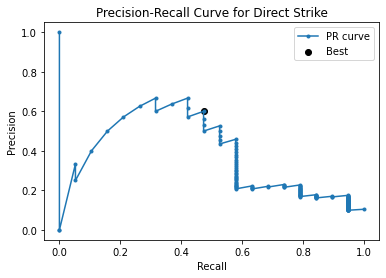

In [19]:
best_thresholds, best_f1_scores = optimize_thresholds(mlp_clf, dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.047906
Class 1, no calibration: 0.032992
Class 2, no calibration: 0.019560
Class 3, no calibration: 0.023650


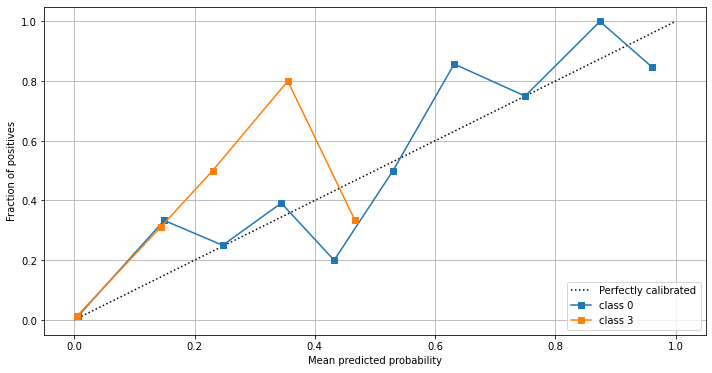

In [16]:
calibration_plot(mlp_clf, dev_X, dev_Y)

In [17]:
preds = predictions_with_thresholds(mlp_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.55844   0.70492   0.62319        61
           1    0.64103   0.64103   0.64103        39
           2    0.66667   0.60000   0.63158        20
           3    0.57143   0.42105   0.48485        19

   micro avg    0.59459   0.63309   0.61324       139
   macro avg    0.60939   0.59175   0.59516       139
weighted avg    0.59896   0.63309   0.61049       139
 samples avg    0.06150   0.06390   0.05932       139



Brier score losses: (the smaller the better)
Class 0, no calibration: 0.227505
Class 1, no calibration: 0.099304
Class 2, no calibration: 0.028529
Class 3, no calibration: 0.043839


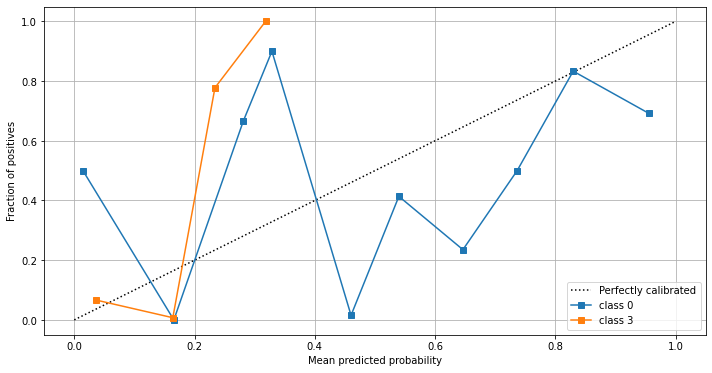

Best Threshold=0.50206, F-Score=0.54286
Best Threshold=0.29052, F-Score=0.57971
Best Threshold=0.17067, F-Score=0.78049
Best Threshold=0.21157, F-Score=0.70968
              precision    recall  f1-score   support

           0    0.47436   0.60656   0.53237        61
           1    0.65517   0.48718   0.55882        39
           2    0.75000   0.75000   0.75000        20
           3    0.90909   0.52632   0.66667        19

   micro avg    0.58696   0.58273   0.58484       139
   macro avg    0.69716   0.59251   0.62697       139
weighted avg    0.62418   0.58273   0.58946       139
 samples avg    0.09026   0.06709   0.07409       139



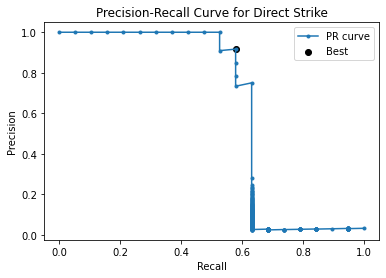

In [25]:
calibrated_mlp_clf = CalibratedClassifierCV(base_estimator=mlp_clf, cv="prefit", ensemble=True, n_jobs=-1).fit(dev_X, dev_Y)
calibration_plot(calibrated_mlp_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = optimize_thresholds(calibrated_mlp_clf, dev_X, dev_Y)
preds = predictions_with_thresholds(calibrated_mlp_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [14]:
save_sklearn_model_to_file(mlp_clf, "mlpclf")

### Attempts to grid search a working configuration

testing proper width:  
first layer: (tested with x, 256 config) from 1024 to 65536, best value is around 32768.  
second layer: (tested with 32768, x config) from 256 to 1024, best value is 256.  

talking about depth, the next_layer := last_layer/2 strategy is used,  
starting from 4096, five layers (among 3-5 layers) are good;  
with five layers, starting from 8192 (among 4096-16384) is good

single layer: candidates identified include 55, 485, 575, 840, 1185, 1300, 2500; but best seems useless

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

param_grid = {
   # "hidden_layer_sizes": [55, 485, 575, 840, 1185, 1300, 2500]
    "batch_size": [64,128,256,512]
}
'''class RandIntMatrix(object):
    def __init__(self, low, high, shape=(1)):
        self.low = low
        self.high = high
        self.shape = shape

    def rvs(self, random_state=None):
        rng = np.random.default_rng(random_state.seed())
        layers = rng.integers(1, self.shape+1,1)
        return rng.integers(self.low, self.high+1, layers)'''

estimator = MLPClassifier(hidden_layer_sizes=(3072,1024,1024,1024,1024), max_iter=MAX_ITERS, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, zero_division=0, average='macro')

'''gscv = RandomizedSearchCV(
    estimator, dict(hidden_layer_sizes=RandIntMatrix(20, 4096, 3)), n_iter=30, scoring=scorer, n_jobs=-1, verbose=2, cv=2, refit=False, random_state=0
).fit(train_X, train_Y)'''

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, n_jobs=-1, verbose=2, cv=3, refit=False).fit(train_X, train_Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......................................batch_size=64; total time= 8.2min
[CV] END ......................................batch_size=64; total time=18.9min
[CV] END ......................................batch_size=64; total time=45.6min
[CV] END .....................................batch_size=128; total time=35.2min
[CV] END .....................................batch_size=512; total time=12.6min
[CV] END .....................................batch_size=256; total time=28.1min
[CV] END .....................................batch_size=256; total time=20.3min
[CV] END ......................................batch_size=64; total time=49.0min
[CV] END ......................................batch_size=64; total time=49.8min
[CV] END .....................................batch_size=128; total time=53.4min


In [34]:
gscv.cv_results_

{'mean_fit_time': array([2887.13907695, 2574.19115623, 1776.24918739,  940.61575834]),
 'std_fit_time': array([108.26294695, 461.98259953, 497.63784791, 146.78306245]),
 'mean_score_time': array([1.32060774, 1.34811409, 1.41170653, 1.15688419]),
 'std_score_time': array([0.08447856, 0.12233984, 0.05909382, 0.13513597]),
 'param_batch_size': masked_array(data=[64, 128, 256, 512],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 64},
  {'batch_size': 128},
  {'batch_size': 256},
  {'batch_size': 512}],
 'split0_test_score': array([0.55410292, 0.68319675, 0.67555257, 0.32423106]),
 'split1_test_score': array([0.54482029, 0.52436495, 0.48958555, 0.48250406]),
 'split2_test_score': array([0.58929059, 0.44827214, 0.47525448, 0.52298024]),
 'mean_test_score': array([0.56273793, 0.55194461, 0.54679753, 0.44323845]),
 'std_test_score': array([0.01915419, 0.09787022, 0.09123135, 0.08575799]),
 'rank_test_score': array

In [10]:
gscv.best_params_

{'hidden_layer_sizes': array([4053, 3636, 3721])}

In [11]:
gscv.best_score_

0.5088469203530442

### MLP Regressor

Seems no configuration will work despite the decent-looking loss values.

In [7]:
mlp_regr = MLPRegressor(
    hidden_layer_sizes=(3072, 2048, 1024, 256),
    batch_size=32,
    max_iter=MAX_ITERS,
    shuffle=True,
    verbose=True,
    alpha=0.01
)

mlp_regr = mlp_regr.fit(train_X, train_Y)

Iteration 1, loss = 56232.90223912
Iteration 2, loss = 134.15978019
Iteration 3, loss = 48.75750038
Iteration 4, loss = 62.44288339
Iteration 5, loss = 0.72779964
Iteration 6, loss = 0.72058224
Iteration 7, loss = 0.73452139
Iteration 8, loss = 0.70043175
Iteration 9, loss = 0.94019241
Iteration 10, loss = 1.73521915
Iteration 11, loss = 7.84810034
Iteration 12, loss = 0.72651579
Iteration 13, loss = 0.97777555
Iteration 14, loss = 1.32945862
Iteration 15, loss = 5.92346928
Iteration 16, loss = 0.67285321
Iteration 17, loss = 0.76277600
Iteration 18, loss = 1.43408110
Iteration 19, loss = 4.56020982
Iteration 20, loss = 1.37099055
Iteration 21, loss = 0.56848399
Iteration 22, loss = 0.54043216
Iteration 23, loss = 0.54737127
Iteration 24, loss = 0.60052432
Iteration 25, loss = 0.56274392
Iteration 26, loss = 0.69087120
Iteration 27, loss = 0.88873043
Iteration 28, loss = 0.58303813
Iteration 29, loss = 0.60452513
Iteration 30, loss = 0.58535113
Iteration 31, loss = 0.66519952
Iteration

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Best Threshold=0.10953, F-Score=0.17758
Best Threshold=0.07202, F-Score=0.11729
Best Threshold=0.03156, F-Score=0.06192
Best Threshold=0.01904, F-Score=0.05891


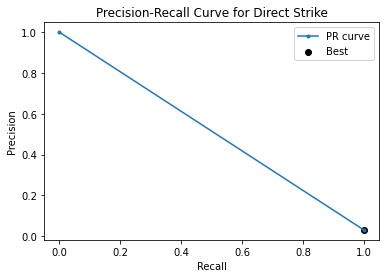

In [11]:
best_thresholds, best_f1_scores = regressor_find_thresholds(mlp_regr, dev_X, dev_Y)

In [12]:
preds = regression_label(mlp_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        61
           1    0.00000   0.00000   0.00000        39
           2    0.00000   0.00000   0.00000        20
           3    0.00000   0.00000   0.00000        19

   micro avg    0.00000   0.00000   0.00000       139
   macro avg    0.00000   0.00000   0.00000       139
weighted avg    0.00000   0.00000   0.00000       139
 samples avg    0.00000   0.00000   0.00000       139



Brier score losses: (the smaller the better)
Class 0, no calibration: 0.088095
Class 1, no calibration: 0.058514
Class 2, no calibration: 0.030928
Class 3, no calibration: 0.029558


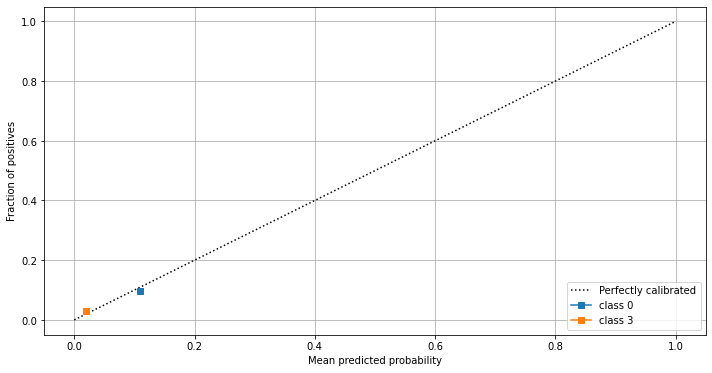

In [15]:
calibration_plot(mlp_regr, dev_X, dev_Y)